# Github Link:
https://github.com/athenafung1/deep-learning-for-healthcare-final-project

# Video Link:
## **TODO: FILL IN**

# Introduction:
---

## Background

  Adverse drug-drug interaction (DDI) is the unintended molecular interactions between drugs. It’s a prominent cause of patient morbidities/mortalities, incurring higher costs and risking patient safety. The difficulty of mitigating this issue stems from a couple of factors: 

  * The molecular structure of drugs are complex, consisting of many units and substructures
  * Drug development is a process that requires highly specialized knowledge
  * Trials to test drugs and post-market surveillance are long, expensive processes

  With respect to applying ML to this topic, there are also a couple of issues:
  
  * There is a relatively light amount of training data that exists, due to the slow reporting of DDI instances
  * Deep learning models have a large number of parameters, making interpretation of the model’s results difficult. One example is that it can be hard to extract the reason for *why* a DDI is occurring.
  * DDIs usually result from the reactions of only a few sub-structures of a drug’s entire molecule, but many drug-drug pairs have significant overlaps on larger but irrelevant substructures. This skews the results of DDI prediction.

  There is major interest in predicting whether two drugs will interact (especially during the design process) to reduce testing/development costs and to improve patient safety.

### The Current State of the Art
 
  Deep learning models have been successfully used to predict DDIs, however such previous models often digest the entire chemical representation, causing learned representations to be potentially biased toward the large, irrelevant substructures and ultimately nullify learned drug similarities and predictions.


# CASTER
---

## Link to CASTER Github:
https://github.com/kexinhuang12345/CASTER

The **ChemicAl SubstrucTurE Representation** framework (CASTER) was introduced as a DDI prediction model, improving on the weaknesses of prior works. CASTER adds a couple of improvements upon previous works. It includes a sequential pattern mining (SPM) method to efficiently decompose a SMILES string into a set of functional drug sub-structures. This accounts for the interaction mechanism between drugs, as interactions depend primarily on the reaction between only a few functional sub-structures. It also includes an autoencoder that works in tandem with a dictionary learning module. This allows the decoding of the latent result, which can help human operators better understand the probability of which sub-structures of a molecule pair are interacting. 

The authors presented the following hypotheses:
1.  The CASTER model will provide more accurate DDI predictions when compared with other established models.
2.  The usage of unlabelled data to generate frequent sub-structure features improves performance in situations with limited labeled datasets.
3.  CASTER’s sub-structure dictionary can help human operators better comprehend the final result.

Based on the paper, it outperformed multiple other models while having a slightly smaller set of parameters, as shown below:

![caster_results.png](img/caster_results.png)

### Architecture

![caster_structure.png](img/caster_block_diagram.png)

The model consists of a few notable parts:
* **Sequential Pattern Mining (SPM)**
    * The SMILEs strings are initially passed through a sequential pattern mining process to find frequently occurring substructures
        * The frequent substructures are put into a dictionary (*u[1-k]*)
    * SMILEs pairs are encoded into multi-hot vectors of their frequent substructures and combined into a single functional representation (*X*)
* **Encoder**
    * The functional representation is passed through the encoder to make a latent feature vector (*z*)
    * The individual freq. substructures, as one-hot vectors, are also passed through the encoder to make a latent dictionary of substructures (*b[1-k]*)
* **Predictor**
    * The latent representation is projected onto the latent dictionary to form a set of coefficients (*r[1-k]*)
    * The coefficients are passed through a standard fully connected NN.
* **Decoder**
    * The latent representation is passed through the decoder to reconstruct the functional representation and help comprehend the result

CASTER is notable for its consideration of the holistic structures of molecules, and the fact that it can provide a more understandable, practical output to a human operator using the tool.

## Scope of Reproducibility:

**We will attempt to test the two following hypotheses in the paper/repo**:

1.  *The CASTER model will provide more accurate DDI predictions when compared with other established models.*
2.  *The usage of unlabelled data to generate frequent sub-structure features improves performance in situations with limited labeled datasets.*

# Methodology:
---
### Setup:
This notebook was run with Python >=3.8. The required packages below can be installed using conda, venv, or pip.
* numpy
* torch
* subword_nmt
* codecs
* pandas
* scikit-learn
* tqdm
* matplotlib

If using the requirements.txt file, run `pip install -r requirements.txt`

### Running the Notebook:
Hit `Run All`.

In [18]:
import numpy as np

#Standard torch imports
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 

#Used for parsing the misc datasets
from subword_nmt.apply_bpe import BPE
import codecs

#For dataset preparation and evaluation
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold

#Misc.
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
torch.manual_seed(2)    # reproducible torch:2 np:3
np.random.seed(3)

There are 2 notable parameters below for running the notebook:

`QUICK_TRAIN_DEMO` = For the sake of a shorter runtime, setting this to `True` trains the model for 128 iterations, instead of multiple epochs.

`LOAD_NO_TRAIN` = Set this to `True` to not train CASTER, and just load the pre-trained model.

Regardless of the parameters above, the logistic regression ablation model will still train.

In [19]:
QUICK_TRAIN_DEMO = True
LOAD_NO_TRAIN = True

#Defines configuration for the data/model/training.
CONFIG = {}

#Learning rate
CONFIG['LR'] = 1e-3
#NOTE: Batch size has been reduced from 256 to 128 to speed up training.
CONFIG['batch_size'] = 128
CONFIG['batch_first'] = True

#Number of pretrain and training epochs
CONFIG['pretrain_epochs'] = 3
CONFIG['train_epochs'] = 3

#Self defined coefficient to multiply with the reconstruction loss.
CONFIG['reconstruction_coefficient'] = 1e-1  # 1e-2
#Defines a stopping point for pre-training the encoder/decoder
CONFIG['recon_threshold'] = 0.0005 
CONFIG['projection_coefficient'] = 1e-1  # 1e-2

#The width of the drug-drug pair's multi-hot functional representation
CONFIG['input_dim'] = 1722
CONFIG['num_class'] = 2

#===== Encoder/Decoder Parameters =====
CONFIG['encode_fc1_dim'] = 500  # encoder fc1
CONFIG['encode_fc2_dim'] = 50  # encoder fc2
CONFIG['decode_fc1_dim'] = 500  # decoder fc1
CONFIG['decode_fc2_dim'] = CONFIG['input_dim']  # decoder reconstruction

#===== Deep Predictor Parameters =====
CONFIG['magnify_factor'] = 100
#NOTE: The deep predictor width for this model was shrunk down to 512 from its original 1024 for the sake of speeding up training
CONFIG['predict_dim'] = 512 # for every layer
CONFIG['predict_out_dim'] = 1 # predictor out

CONFIG['lambda1'] = 1e-2  # L1 regularization coefficient
CONFIG['lambda2'] = 1e-1  # L2 regulatization coefficient
CONFIG['lambda3'] = 1e-5  # L2 regulatization coefficient


##  Data:
The data that CASTER ingests consists of 3 datasets, already integrated in the repo:
  * unsup_dataset.csv = A dataset of randomly combined pairs of SMILEs strings drawn from FooDB (a DB of food constituent molecules) and all drugs, (including experimental, investigational, and nutraceutical) drawn from DrugBank
    * This unsupervised dataset is used to help find frequent SMILEs substructures and train the encoder/decoder
  * BIOSNAP/sup*.csv = A dataset from Stanford's Biomedical Network Dataset indicating pairs of SMILEs strings and presence of DDI
    * These are the supervised datasets for training the predictor
  * subword_units_map.csv = The 1722 frequent patterns extracted from the unsupervised strings, already produced by the sequential pattern mining (SPM) routine

The 2 cells below define and load the data.

In [20]:
#===== DATASET DEFINITIONS =====
vocab_path = "data/codes.txt"
bpe_codes_fin = codecs.open(vocab_path)
bpe = BPE(bpe_codes_fin, merges=-1, separator='')

#Get frequent substructures
vocab_map = pd.read_csv('data/subword_units_map.csv')
idx2word = vocab_map['index'].values
words2idx = dict(zip(idx2word, range(0, len(idx2word))))

#===== Helper functions =====
#Map 2 smiles strings into multi-hot representations of their substructures.
def smiles_2_index(s1, s2):
    t1 = bpe.process_line(s1).split() #split
    t2 = bpe.process_line(s2).split() #split
    i1 = [words2idx[i] for i in t1] # index
    i2 = [words2idx[i] for i in t2] # index
    return i1, i2

#Combines both multi-hot representations into a single multi-hot (the functional representation)
def index_2_multi_hot(i1, i2):
    v_d = np.zeros(len(idx2word),dtype=np.float32)
    v_d[i1] = 1
    v_d[i2] = 1
    return v_d

#Combination of above: Takes two smiles strings and turns them into the multi-hot functional representation.
def smiles_2_vector(s1, s2):
    i1, i2 = smiles_2_index(s1, s2)
    v_d = index_2_multi_hot(i1, i2)
    return v_d

#===== Datasets =====
class sup_data(data.Dataset):

    def __init__(self, list_IDs, labels, df_ddi):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.df = df_ddi
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        index = self.list_IDs[index]
        # Load data from sample and get multi-hot
        s1 = self.df.iloc[index].Drug1_SMILES
        s2 = self.df.iloc[index].Drug2_SMILES
        v_d = smiles_2_vector(s1, s2)
        #Get label
        y = self.labels[index]
        #Return combined multi-hot and its label.
        return v_d, y
    
class unsup_data(data.Dataset):

    def __init__(self, list_IDs, df):
        'Initialization'
        self.list_IDs = list_IDs
        self.df = df

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        index = self.list_IDs[index]
        s1 = self.df.iloc[index].input1_SMILES
        s2 = self.df.iloc[index].input2_SMILES
        v_d = smiles_2_vector(s1, s2)
        return v_d

In [21]:
#Read datasets
df_unsup = pd.read_csv('data/unsup_dataset.csv', 
                       names = ['idx', 'input1_SMILES', 'input2_SMILES', 'type']).drop(0)# pairs dataframe input1_smiles, input2_smiles
df_ddi = pd.read_csv('data/BIOSNAP/sup_train_val.csv')  # ddi dataframe drug1_smiles, drug2_smiles
df_ddi.label = df_ddi.label.astype('float32')

#Print some basic info about the datasets 
print("="*30)
print("TOTAL UNSUPERVISED SET")
print("="*30)
print("# of samples:",len(df_unsup))
print("# of drug-food pairs:",sum(df_unsup.type == "df_pair"))
print("# of drug-drug pairs:",sum(df_unsup.type == "dd_pair"))
print("\n")
print("="*30)
print("BIOSNAP TRAIN/VAL SET")
print("="*30)
print("# of samples:",len(df_ddi))
print("# of DDIs:",sum(df_ddi.label == 1.0))

#K-fold cross-validation.
kf = KFold(n_splits = 8, shuffle = True, random_state = 3)

#Get the 1st fold index
fold_index = next(kf.split(df_ddi), None)

ids_unsup = df_unsup.index.values
partition_sup = {'train': fold_index[0], 'val': fold_index[1]}
labels_sup = df_ddi.label.values

LOADER_PARAMS = {
    'batch_size': CONFIG["batch_size"],
    'shuffle': True,
    'num_workers': 0
    }

unsup_set = unsup_data(ids_unsup, df_unsup)
unsup_generator = data.DataLoader(unsup_set, **LOADER_PARAMS)

training_set = sup_data(partition_sup['train'], labels_sup, df_ddi)
training_generator_sup = data.DataLoader(training_set, **LOADER_PARAMS)

validation_set = sup_data(partition_sup['val'], labels_sup, df_ddi)
validation_generator_sup = data.DataLoader(validation_set, **LOADER_PARAMS)

TOTAL UNSUPERVISED SET
# of samples: 441853
# of drug-food pairs: 220926
# of drug-drug pairs: 220927


BIOSNAP TRAIN/VAL SET
# of samples: 66432
# of DDIs: 33243


## Model Definition:

Based on CASTER's github, the model was defined with the following parameters:
* Encoder/Decoder: 2 Layer 500x50 NNs with ReLU activations
* Predictor: 7 Layer 1024 wide NNs with ReLU activations
    * For the sake of speeding up local training, the predictor width was reduced to 512 and we reduced the depth by 1 layer.
* Optimizer: Adam with learning rate = 1e-3
* Batch Size: 256
    * For the sake of speeding up local training, the batch size was trimmed to 128.

## **TODO: Expand**

The cell below defines and instantiates the model.


In [22]:
class CASTER(nn.Sequential):

    def __init__(self, **config):
        super(CASTER, self).__init__()
        self.input_dim = config['input_dim']
        self.num_class = config['num_class']
        self.lambda3 = config['lambda3']        
        self.encode_fc1_dim = config['encode_fc1_dim']
        self.encode_fc2_dim = config['encode_fc2_dim']
        self.decode_fc1_dim = config['decode_fc1_dim']
        self.decode_fc2_dim = config['decode_fc2_dim']
        self.predict_dim = config['predict_dim']
        self.predict_out_dim = config['predict_out_dim']
        self.mag_factor = config['magnify_factor']        

        # encoder:
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.encode_fc1_dim),
            nn.ReLU(True),
            nn.Linear(self.encode_fc1_dim, self.encode_fc2_dim)
        )
        
        # decoder:
        self.decoder = nn.Sequential(
            nn.Linear(self.encode_fc2_dim, self.decode_fc1_dim),
            nn.ReLU(True),
            nn.Linear(self.decode_fc1_dim, self.decode_fc2_dim)
        )

        # predictor:
        self.predictor = nn.Sequential(
            # layer 1
            nn.Linear(self.input_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 2
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 3
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 4
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 5
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 6
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, 64),
            nn.ReLU(True),
            # output layer
            nn.Linear(64, self.predict_out_dim)
        )

    def dictionary_encoder(self, z, latent_dict):
        '''
        :param z: batch_size x encode_fc2_dim
        :param latent_dict: encode_fc2_dim x eta
        :return: sparse code r: batch_size x eta
        '''       
        
        DTD = torch.matmul(latent_dict, latent_dict.transpose(2, 1))  # D is Dictionary;  D^T D encode_dim x eta
        temp = DTD + self.lambda3 * torch.eye(self.input_dim)
        DTD_inv = torch.inverse(temp)  # (D^T D + \lambda2 I )^{-1} D^T D, eta x eta
        DTD_inv_DT = torch.matmul(DTD_inv, latent_dict)  

        r = z[:,None,:].matmul(DTD_inv_DT.transpose(2, 1)).squeeze(1) # batch_size x eta    
        return r

    def forward(self, x_vec):
        '''
        :param x_vec: batch_size x width of multi-hot functional
        :return: recon, r_vec, score
        '''
        _, x_width = x_vec.shape
        
        # Encode functional representation into latent representation 
        z_vec = self.encoder(x_vec)
        
        # Create latent dictionary using encoder
        latent_dict = self.encoder(torch.eye(x_width))
        latent_dict = latent_dict.mul(x_vec[:,:,None]) 
        
        # Use dictionary to get coeffs/r_vec
        r_vec = self.dictionary_encoder(z_vec, latent_dict)

        # Pass coeffs through the deep predictor
        score = self.predictor(self.mag_factor * r_vec)

        # Decode latent representation
        recon_temp = self.decoder(z_vec)
        reconstructed = torch.sigmoid(recon_temp)
        
        # print(reconstructed, r_vec, score, latent_dict, z_vec)
        return reconstructed, r_vec, score, latent_dict, z_vec

#Instantiated model
caster_model = CASTER(**CONFIG)

## Training:
Training proceeds in two phases. 
1. **Pre-training:**
    * This phase is focused on getting the autoencoder to find the most efficient latent representation for the functional representation. Note that the classification loss is excluded in the phase, so the autoencoder gets a "head start".
2. **Training:**
    * This phase trains the predictor with the linear coefficients (combination of latent dictionary w/ latent representation). Classification loss is added back into this phase.

### Notes on Hardware and Runtime:
The workstation this notebook was run on contains a Ryzen 7 5700x CPU and 48 GB of RAM. We did not utilize any CUDA enabled GPU.
This expectedly makes the time per iteration of each epoch somewhat slower. For example: 1 epoch of the pre-training cycle containing 3452 iterations, thus the time to train per epoch would be around *13 hours*.

For the sake of brevity, we've added a `QUICK_TRAIN_DEMO` parameter was added into the `CONFIG` cell to allow for a quick demo of 128 iterations.

On Windows, the runtimes were:
* Pre-Training & Training : ~50 sec / iteration
* Evaluation : ~12 sec / iteration

However, using WSL (Ubuntu 22.04), runtimes were:
* Pre-Training & Training : ~13.5 sec / iteration
* Evaluation : ~6 sec / iteration

Performance profiling the script revealed that the slowest operation was the matrix inverse operation in the dictionary encoder.


In [23]:
#Misc loss histories
loss_r_history = []
loss_p_history = []
loss_c_history = []
loss_history = []

#How many epochs to devote to training the encoder/decoder
PRETRAIN_EPOCHS = CONFIG['pretrain_epochs']
#Defines an early stopping point for pre-training the encoder/decoder
RECON_THRESH = CONFIG['recon_threshold']
#Self defined coefficient to multiply with the reconstruction loss.
RECON_LOSS_COEFF = CONFIG['reconstruction_coefficient']
#How many epochs to train the full model
TRAIN_EPOCHS = CONFIG["train_epochs"]
PROJ_COEFF = CONFIG['projection_coefficient']
LAM1 = CONFIG['lambda1']
LAM2 = CONFIG['lambda2']

LR = CONFIG['LR']
BATCH_SIZE = CONFIG["batch_size"]
opt = torch.optim.Adam(caster_model.parameters(), lr = LR)

In [24]:
#===== PRE-TRAINING =====
if not LOAD_NO_TRAIN:

    len_unsup = len(unsup_generator)

    if QUICK_TRAIN_DEMO:
        print("QUICK DEMO ACTIVE")

    for pre_epo in range(PRETRAIN_EPOCHS):

        #Use unsupervised datasat to train encoder/decoder
        for iter_idx, v_D in tqdm(enumerate(unsup_generator)):
            v_D = v_D.float()

            recon, code, score, Z_f, z_D = caster_model(v_D)
            
            loss_r = RECON_LOSS_COEFF * F.binary_cross_entropy(recon, v_D)
            
            loss_p = PROJ_COEFF * (torch.norm(z_D - torch.matmul(code, Z_f)) + \
                    LAM1 * torch.sum(torch.abs(code)) / BATCH_SIZE + \
                    LAM2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            
            total_loss = loss_r + loss_p
            
            loss_r_history.append(loss_r.detach())
            loss_p_history.append(loss_p.detach())
            loss_history.append(total_loss.detach())

            opt.zero_grad()
            total_loss.backward()
            opt.step()
            
            if(iter_idx % 10 == 0):
                print('Pre-Training at Epoch ' + str(pre_epo) + \
                        ' iteration ' + str(iter_idx) + \
                        ', total loss is ' + '%.3f' % (total_loss.cpu().detach().numpy()) + \
                        ', proj loss is ' + '%.3f' % (loss_p.cpu().detach().numpy()) + \
                        ', recon loss is ' + '%.3f' % (loss_r.cpu().detach().numpy()))
            
            # save pretraining checkpoint for reuse
            if iter_idx == int(len_unsup/4):
                torch.save(caster_model, 'model_pretrain_checkpoint_1.pt')
            if iter_idx == int(len_unsup/2):
                torch.save(caster_model, 'model_pretrain_checkpoint_1.pt')

            #If the reconstruction loss is smaller than the specified threshold, finish the pre-training and go train.
            if QUICK_TRAIN_DEMO and iter_idx >= 128 or loss_r < RECON_THRESH:
                break
        if QUICK_TRAIN_DEMO:
            break
    print("Done with pre-training.")

In [25]:
#===== TRAINING =====

if not LOAD_NO_TRAIN:
    sigmoid = torch.nn.Sigmoid()
    bce_loss = torch.nn.BCELoss()

    if QUICK_TRAIN_DEMO:
        print("QUICK DEMO ACTIVE")

    for tr_epo in range(TRAIN_EPOCHS):
        for iter_idx, (v_D, label) in tqdm(enumerate(training_generator_sup)):
            v_D = v_D.float()
            recon, code, score, Z_f, z_D = caster_model(v_D)
            label = Variable(torch.from_numpy(np.array(label)).long())
            n = torch.squeeze(sigmoid(score))
            
            loss_c = bce_loss(n, label.float())
            loss_r = RECON_LOSS_COEFF * F.binary_cross_entropy(recon, v_D)
            
            loss_p =    PROJ_COEFF * (torch.norm(z_D - torch.matmul(code, Z_f)) + \
                        LAM1 * torch.sum(torch.abs(code)) / BATCH_SIZE + \
                        LAM2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            
            total_loss = loss_c + loss_r + loss_p
            loss_r_history.append(loss_r.detach())
            loss_p_history.append(loss_p.detach())
            loss_c_history.append(loss_c.detach())
            loss_history.append(total_loss.detach())

            opt.zero_grad()
            total_loss.backward()
            opt.step()

            if iter_idx % 10 == 0:        
                print(  'Training at Epoch ' + str(tr_epo) + \
                        ' iteration ' + str(iter_idx) + \
                        ', total loss is ' + '%.3f' % (total_loss.detach().numpy()) + \
                        ', proj loss is ' + '%.3f' % (loss_p.detach().numpy()) + \
                        ', recon loss is ' + '%.3f' % (loss_r.detach().numpy()) + \
                        ', classification loss is ' + '%.3f' % (loss_c.detach().numpy()))
            
            if QUICK_TRAIN_DEMO and iter_idx >= 128:
                break
        if QUICK_TRAIN_DEMO:
            break
        
    #Save the final model.
    torch.save(caster_model, 'model_nn_trained.pt')
    print("Done with training.")

## Ablation Model: Logistic Regression

![ablation_location](img/where_to_put_ablation.png)

One of the ablations we proposed (and was also suggested in the paper) was using logistic regression (LR) versus CASTER's deep predictor. Specifically, the pair's functional representation (sub-structured/post pattern-mined) is classified using LR. According to the paper, though far lighter in parameter count, it was not chosen due its weaker performance. Weaker performance is expected since the decision boundary for determining DDIs would presumably be highly non-linear. For brevity, definition and training have been combined into the cell below. We train the log reg model for 36 epochs using SGD at LR=1e-3.

In [26]:
class simple_log_reg(nn.Module):

    def __init__(self, n_inputs, n_outputs):
        super(simple_log_reg, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    
    def forward(self,x):
        pred = torch.sigmoid(self.linear(x))
        return pred[:,-1]

n_inputs = CONFIG["input_dim"]
n_outputs = 1

#Instantiate log reg classifier
log_reg_model = simple_log_reg(n_inputs, n_outputs)

#Using SGD for simplicity
log_reg_optimizer = torch.optim.SGD(log_reg_model.parameters(), lr=0.001)
log_reg_criterion = torch.nn.BCELoss()

epochs = 36
print("Training log reg for {} epochs".format(epochs))
for epoch in tqdm(range(epochs)):
    for x_vec, y in training_generator_sup:
        log_reg_optimizer.zero_grad()
        log_reg_y_pred = log_reg_model(x_vec)
        total_loss = log_reg_criterion(log_reg_y_pred, y)
        total_loss.backward()
        log_reg_optimizer.step()
    if epoch % 8 == 0:
        print('Epoch: {}. Loss: {}.'.format(epoch, total_loss.item()))
print("Done training LR.")

Training log reg for 36 epochs


  3%|▎         | 1/36 [00:06<03:50,  6.58s/it]

Epoch: 0. Loss: 0.6876088976860046.


 25%|██▌       | 9/36 [00:47<02:17,  5.11s/it]

Epoch: 8. Loss: 0.6620131134986877.


 47%|████▋     | 17/36 [01:27<01:36,  5.08s/it]

Epoch: 16. Loss: 0.6415309906005859.


 69%|██████▉   | 25/36 [02:08<00:55,  5.08s/it]

Epoch: 24. Loss: 0.6202517151832581.


 92%|█████████▏| 33/36 [02:48<00:15,  5.07s/it]

Epoch: 32. Loss: 0.5596653819084167.


100%|██████████| 36/36 [03:03<00:00,  5.11s/it]

Done training LR.


# Results:
---
To begin the evaluation process, we iterate through a test data set using a data loader to obtain the predictions (y_pred) from the model for each input (v_D). We then use the ground truth labels (y_label) to which we compare our predictions to calculate the evaluation metrics.

The evaluation metrics used here include some of the most commonly used metrics to assess the performance of binary models: 

* **Average Precision Score**: Measures the precision-recall trade-off by summarizing the precision-recall curve as a weighted mean of precisions achieved at various thresholds.

* **Area under the ROC Curve (AUC)**: Describes the trade-off between true-positive rate and false-positive rate. It essentially quantifies the ability of the model to distingush between classes.

* **F1-Score**: Harmonic mean of precision and recall, combines precision and recall scores into a single value.

In [28]:
if LOAD_NO_TRAIN:
    caster_model = torch.load("model_nn_trained.pt")

params = {
        'batch_size': 128,
        'shuffle': True,
        'num_workers': 0
        }

test_set = sup_data(df_ddi.index.values, labels_sup, df_ddi)
test_generator_sup = data.DataLoader(test_set, **params)

log_reg_y_pred = []
log_reg_y_label = []

caster_y_pred = []
caster_y_label = []

#Set caster model to eval
caster_model.eval()

#Set log reg to eval
log_reg_model.eval()

sigmoid = torch.nn.Sigmoid()

if QUICK_TRAIN_DEMO:
    print("QUICK DEMO ACTIVE")

for iter_idx, (v_D, label) in tqdm(enumerate(test_generator_sup)):
    label_ids = label.to('cpu').numpy()

    recon, r_vec, score, latent_dict, z_D = caster_model(v_D.float())
    logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy()
    caster_y_label = caster_y_label + label_ids.flatten().tolist()
    caster_y_pred = caster_y_pred + logits.flatten().tolist()

    log_reg_outputs = log_reg_model(v_D.float())
    log_reg_y_label = log_reg_y_label + label_ids.flatten().tolist()
    log_reg_y_pred = log_reg_y_pred + log_reg_outputs.flatten().tolist()
    
    #Stop early at 32 iterations if QUICK_DEMO
    if QUICK_TRAIN_DEMO and iter_idx > 32:
        break

QUICK DEMO ACTIVE


33it [03:26,  6.24s/it]


In the following cells, we will plot the precision-recall curve and the AUC described above. The precision-recall curve demonstrates the precision of the model at various recall levels. This gives us an idea of the model's ability to identify positive occurences with false positives minimized.

Overall, using these metrics and evaluations, we get a clear picture of the model's performance across different thresholds.

CASTER AP: 0.9246268692869966
CASTER PR-AUC: 0.9246032742572213


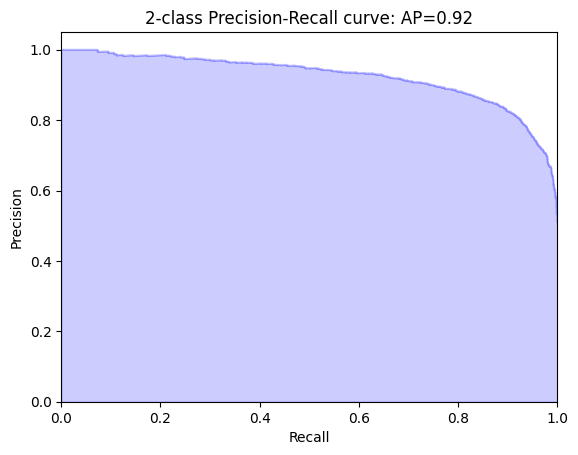

In [32]:
#===== PR-AUC =====
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

average_precision = average_precision_score(caster_y_label, caster_y_pred)
caster_precisions, caster_recalls, pr_thresholds = precision_recall_curve(caster_y_label, caster_y_pred)

plt.step(caster_recalls, caster_precisions, color='b', alpha=0.2,
         where='post')
plt.fill_between(caster_recalls, caster_precisions, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

print("CASTER AP:",average_precision)

caster_pr_auc = auc(caster_recalls, caster_precisions)
print("CASTER PR-AUC:", caster_pr_auc)

CASTER ROC-AUC: 0.9267690495844981
LR ROC-AUC: 0.8401494120687072


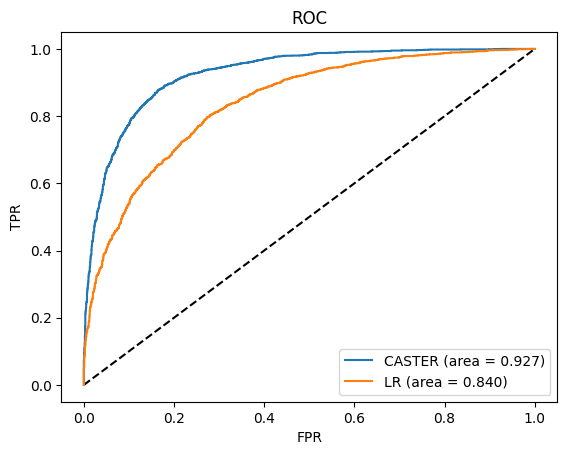

In [33]:
#===== ROC CURVE =====

from sklearn.metrics import roc_curve, auc

caster_fpr, caster_tpr, thresholds = roc_curve(caster_y_label, caster_y_pred)
caster_roc_auc_score = auc(caster_fpr, caster_tpr)

log_reg_fpr, log_reg_tpr, lr_thresholds = roc_curve(log_reg_y_label, log_reg_y_pred)
log_reg_roc_auc_score = auc(log_reg_fpr, log_reg_tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(caster_fpr, caster_tpr, label='CASTER (area = {:.3f})'.format(caster_roc_auc_score))
plt.plot(log_reg_fpr, log_reg_tpr, label='LR (area = {:.3f})'.format(log_reg_roc_auc_score))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='best')
print("CASTER ROC-AUC:",caster_roc_auc_score)
print("LR ROC-AUC:",log_reg_roc_auc_score)

In [36]:
#===== F1 Calculation =====
f1_scores = 2*caster_recalls * caster_precisions / (caster_recalls+caster_precisions)
print('Best threshold: ', pr_thresholds[np.argmax(f1_scores)])
print('Best F1: ', np.max(f1_scores))
print("\n===== CASTER BIOSNAP PERFORMANCE SUMMARY =====")
print("ROC-AUC:",caster_roc_auc_score)
print("PR-AUC:",caster_pr_auc)
print("F1:",np.max(f1_scores))

Best threshold:  0.4477385878562927
Best F1:  0.8638149279790485

===== CASTER BIOSNAP PERFORMANCE SUMMARY =====
ROC-AUC: 0.9267690495844981
PR-AUC: 0.9246032742572213
F1: 0.8638149279790485


# Results (Continued):

---
![caster_results_again](img/caster_results.png)

Re-iterating what we aim to reproduce:

1.  *The CASTER model will provide more accurate DDI predictions when compared with other established models.*
2.  *The usage of unlabelled data to generate frequent sub-structure features improves performance in situations with limited labeled datasets.*

Once again, the above table shows the claimed performance of CASTER, compared to the other established methods. Despite only training for 128 iterations with `QUICK_TRAIN_DEMO` enabled, our local CASTER performed well relative to the other methods. Our scores were similar but did not exactly match the ones described in the paper; They were slightly higher across the board, including the log reg ablation. Regardless, this still demonstrates both of the hypotheses we aimed to test:

1. **Yes**, CASTER does indeed provide more accurate DDI predictions.
2. **Yes**, utilizing the frequent chemical sub-structures from an unlabelled dataset *does improve performance* despite a limited labeled dataset.

# Discussion :
---

## TODO: Expand

* Is the paper reproducible?
    * **Yes.**, we’ve demonstrated that we can instantiate, train, and evaluate the model, thus we believe that it is, indeed, reproducible. Our results suggest that utilzing frequent sub-structures is a promising method for achieving improved DDI prediction performance with a smaller parameter set.

* What was easy?
    * One of the aspects of the paper reproduction that we found straightforward was understanding the authors’ intentions in the code. Although the script was not accompanied by copious documentation, the comments in the code, a relatively clear procedural flow in the script, and slowly working through the paper helped us understand what is being accomplished with the provided code.
    
* What was difficult?
    * One aspect that we found difficult was finding the right computing power to handle the scale of computation demanded by the CASTER model. In the subsequent project phase, we plan to migrate our replication efforts to cloud infrastructure thereby availing ourselves of improved computational abilities.

* Future Plans:
    * In the next phase, we plan on either migrating our notebook to Google Colab (this free version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability), Google Colab Pro (which grants access to premium V100 or A100 Nvidia GPUs), Google Cloud Platform, or Kaggle (which grants access to two T4 GPUs and one A100 GPU subject to quota restrictions and availability as well). Depending on the model parameter sizes and training time, we will use one or more of these platforms, possibly in parallel. We will also finish our planned ablations, refactor, and add more detailed comments for a more readable and easily understandable notebook.

# References

1.   Huang, K., Xiao, C., Hoang, T., Glass, L., & Sun, J. (2020, April). Caster: Predicting drug interactions with chemical substructure representation. In Proceedings of the AAAI conference on artificial intelligence (Vol. 34, No. 01, pp. 702-709).

